### Code for [Robust Policy Optimization in Continuous-Time Mixed $H_2/H_\infty$ Stochastic Control](https://scriptedonachip.com/downloads/Papers/h2hinf.pdf) by Leilei Cui and Lekan Molu.

In [2]:
import copy 
import scipy
import numpy as np
import pandas as pd
import control as ct
import scipy.linalg as sla 
from scipy.signal import place_poles
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'") 
    
import sys, os 

sys.path.append("..")
from utils import *
from dynsys import * 
from linearsys import * 
from hinfinity import * 

### Model-Based Algorithm

+ We resort to the three link pendulum with two active joints and one passive joint as described in our paper.

+ There is inherent Brownian noise in the model due to the chattering of the passive link and its loose connection to its hinge support.

+ We are tasked with solving a model-based robust policy optimization in continuous-time mixed design settings.

### Set up Solvers for Riccati Equations and Matrix Identities' Definitions

In [125]:
def QKp_mat(Q, Kp, R):
    return Q + Kp.T@R@Kp 

def AKp_mat(A, B, K):
    return A - B@K

def AKLpq_mat(AKp, D, Lq):
    return AKp + D@Lq 

def AKgamma(AKp, gamma, D, PKp):
    return AKp + 1/(gamma**2)*D@D.T@PKp 

def Kp_plus(R, B, PKL_pq):
    return np.linalg.inv(R) @ B.T @ PKL_pq

def Lq_plus(gamma, D, PKL_pq):
    return 1/(gamma**2)*D.T@PKL_pq 

import scipy as sp 
def outer_loop_riccati(A, B, D, R, Kp, Q,  PKp, PKL_pq=None, gamma=5, rtol=1e-8):
    """Recursively solve the outer loop's Riccati equation (10a) in the paper given by

        . A_K^{p^\top} P_{K}^{p^\top} + P_K^p A_K^p + Q_K^p + \gamma^{-2} P_K^p D D^\top P_K^p = 0
        where 
            . p is an index of the outer loop in the policy iteration of Algorithm 1.
            . A_K^p is the outer loop's closed-loop transition matrix given by 
                A_K^p = A - B K_p.
            . P_K^p is the cost matrix associated with the Riccati equation.
            . Q_K^p = C^\top C + K_p^\top R K_p.
            . gamma is the level of noise attenuation we want. This is user specified.

        Returns
        =======
        PKp, Kp_cur
    """

    n = A.shape[0]

    if PKL_pq is None:
        PKL_pq = np.ones((n,n), dtype=float)
        
    diff = np.linalg.norm((PKp - PKL_pq), ord='fro')
    print(f"diff: {diff}")
    while diff <= rtol:
        AKp = AKp_mat(A, B, Kp)
        QKp = Q + Kp.T @ R @ Kp 

        PKp += (AKp.T @ PKp + PKp @ AKp + QKp + 1/(gamma**2) * PKp @ D @ D.T @ PKp) 

        # updates 
        Kp  = Kp_plus(R, B, PKp)

        diff = np.linalg.norm((PKp - PKL_pq), ord='fro')

        print("diff: ", diff)

    return PKp, Kp

def inner_loop_riccati(A, B, D, Kp, QKp, PKL_pq, PK_p=None, Lq_cur=None, gamma=5, rtol=1e-8):
    """Recursively solve the inner loop's Riccati equation (11a) in the paper given by

        . A_{K,L}^{p,q^\top} P_{K,L}^{p,q^\top} + P_{K,L}^{p,q^\top} A_{K,L}^{p,q^\top}  \
                + Q_{K,L}^{p,q^\top} + \gamma^{-2} P_{K,L}^{p,q^\top} D D^\top P_{K,L}^{p,q^\top} = 0
        where 
            . p is an index of the outer loop in the policy iteration of Algorithm 1.
            . q is an index of the inner loop in the policy iteration of Algorithm 1.
            . A_{K,L}^{p,q^\top} is the inner loop's closed-loop transition matrix given by 
                A_{K,L}^{p,q^\top} = A_K^p + D L_q(K_p).
            . P_{K,L}^{p,q^\top} is the cost matrix associated with the Riccati equation above.
            . Q_{K,L}^{p,q^\top} = C^\top C + K_p^\top R K_p.
            . gamma is the level of noise attenuation we want. This is user specified.
        
        Returns
        =======
        PKL_pq, Lq_cur
    """

    n = A.shape[0]
    AKp = AKp_mat(A, B, Kp)
    if Lq_cur is None:
        Lq_cur = Lq_plus(gamma, D, PKL_pq)
    AKL_pq = AKLpq_mat(AKp, D, Lq_cur)

    if PK_p is None:
        PK_p = np.ones((n,n), dtype=float)

    while np.linalg.norm((PK_p - PKL_pq), ord='fro') <= rtol:

        PKL_pq = AKL_pq.T @ PKL_pq + PKL_pq @ AKL_pq + QKp - 1/(gamma**2) * Lq_cur @ Lq_cur

        Lq_cur =  Lq_plus(gamma, D, PKL_pq)
        AK_p   = AKp_mat(A, B, Kp)
        AKL_pq = AKLpq_mat(AKp, D, Lq_cur)

    return PKL_pq, Lq_cur

### Set up Triple Inverted Pendulum Parameters

In [107]:
A = np.array(([
                [12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
                [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
                [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]
            ]))

A = np.vstack((
                np.hstack((np.zeros((3,3)), np.eye(3))), A               
                ))
B = np.array((
            [
                [-50.0, 6.12],
                [174.4, -38.93],
                [-124.2, 48.62]
            ]))
B = np.vstack((np.zeros((3,2)), B))

C = np.vstack((np.diag((np.ones(6))), np.zeros((2,6))))

D = np.vstack(( np.zeros((3,3)), np.eye(3) ))
E = np.vstack(( np.zeros((6,2)), np.eye(2) ))

gamma = 5

# Matrix definitions

Q = C.T @ C 
R = E.T @ E
K = np.array(( [ [-257.5, -96.0, -39.4,  -85.6, -37.5,  -19.8],
                 [-628.4, -236.7,  -94.1, -208.6,  -93.3,  -46.7]
            ]   ))
Q_K0 = QKp_mat(Q, K,  R) 
P_K0 = copy.copy(Q_K0 )

In [3]:
qd_dot = lambda t: np.array(([t, 2*t]))
qd_dot(2)

array([2, 4])

In [108]:
# Try solving for P0 using cvx_py
"""
LMI for equation 10 can be thus written:

        [I_n    P_K^P][ [Q_K^p + A_K^{p\top} P_K^p + P_K^p A_K^p, 0_{nxn}] ]           [I_n    P_K^P]^\top
                      [ [0_{n x n},                          \gamma^{2} D D^\top]] 

     = Q_K^p + A_K^{p\top} P_K^p + P_K^p A_K^p+  \gamma^{2} D D^\top = 0

     ^^^Looks like cvxpy doesn't like thje closed loop LMI expression as above esp when gamma is there. 
     Use this instead:
      [I_n    K^p][ [Q + A_K^{p\top} P_K^p + P_K^p A_K^p, -P_K^p B ]           [I_n    K_p]^\top
                      [ B.T@[P_K^p ,            \gamma^{2} D D^\top]] 

     = Q_K^p + A_K^{p\top} P_K^p + P_K^p A_K^p+  \gamma^{2} D D^\top = 0

"""
import cvxpy 

n = A.shape[0]
P = cvxpy.Variable((n,n), symmetric=True) 
gamma = cvxpy.Variable() 

AK = A - B@K

LMI = cvxpy.bmat([
                [A.T @ P + P @A + Q, P@B],
                [B.T@P,      R] # (gamma**2) * P@D @ D.T@P
                ])                
cons = [LMI >>0, P==P.T, gamma>=0]
prob = cvxpy.Problem(cvxpy.Minimize(gamma), constraints=cons)
prob.solve()


# solve PKL
PKL = cvxpy.Variable((n,n), symmetric=True) 
gamma2 = cvxpy.Variable() 
Lq = Lq_plus(5, D, P.value)
AKL = AKLpq_mat(AK, D, Lq)

ValueError: Unrecognized character l in format string

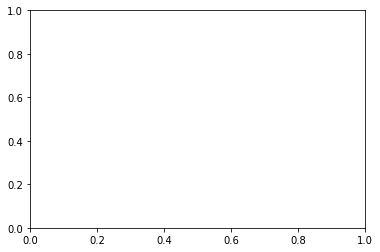

In [6]:
### Class \mathcal{K}-\ell function
r = np.linspace(1, 5, 50)
s = 4*r 
c = 0.1
beta = r**c * np.exp(-s)
plt.plot(beta, r, 'color', 'blue')
plt.plot(beta, s, 'color', 'red')
plt.show()

In [126]:
pbar=40
Kp = copy.copy(K)
for p in range(pbar):
    Q_Kp = QKp_mat(Q, Kp,  R) 
    PKp, Kp = outer_loop_riccati(A, B, D, R, Kp, Q, PKp=P.value, PKL_pq=None, gamma=5, rtol=1e-8)
    print(f"Outer loop iter: {p}: Kp: {Kp}\n")

diff: 6.150981614077653
Outer loop iter: 0: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 1: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 2: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 3: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 4: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 5: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077653
Outer loop iter: 6: Kp: [[-257.5  -96.   -39.4  -85.6  -37.5  -19.8]
 [-628.4 -236.7  -94.1 -208.6  -93.3  -46.7]]

diff: 6.150981614077

In [ ]:
def system(dt, x, u):
    '''
    Discretized Linear Dynamics of the system dx = (Ax+Bu)dt + Ddw by E-M
    Input:
        dt: time step to 
        x: state of the system, 6 dim
        u: control input of the system, 2 dim
    Output:
        x_next: state at the next step
    '''
    A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
    A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
                   [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
                   [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
    A = np.concatenate((A, A_), axis = 0)
    
    B = np.array([[-50.0, 6.12],
                  [174.4, -38.93],
                  [-124.2, 48.62]])
    B = np.concatenate((np.zeros((3,2)), B), axis = 0)
    
    D = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 0)
    
    xi = np.random.normal(0,1,3)
    x_next = x + (A@x+B@u)*dt + D@xi*np.sqrt(dt)
    
    return x_next


def int_system(dt, tf, x0, K, sigma):
    '''
    Intergrate the sde from 0 to tf
    Input:
        dt: time step to discrete the system
        tf: terminal time of the integral
        x0: initial state
        K: Controller
        sigma: magnitude of exploratory noise
    Output:
        X: state trajectory from 0 to tf
        U: input trajectory from 0 to tf
    '''
    N = int(tf/dt)
    X = np.zeros((N+1,6))
    U = np.zeros((N,2))
    X[0,:] = x0
      
    y = np.zeros(2)
    
    for i in range(N):
        t = i*dt
        y = y - y*dt + np.random.normal(0,1,2)*np.sqrt(dt)
        u = -K@X[i,:] + sigma*y
        x_next = system(dt, X[i,:], u)
        X[i+1,:] = x_next
        U[i,:] = u
        
    return X, U
        

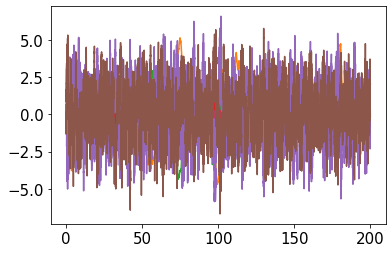

In [ ]:
# run system and collect the data
dt = 0.001
tf = 1500.0
sigma = 10
K_init = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]]) 
# x0 = np.random.normal(0,1,6)
x0 = np.zeros(6)
T = np.arange(0., tf+dt, dt)
X, U = int_system(dt, tf, x0, K_init, sigma)

plt.plot(T, X)
plt.show()

In [ ]:
# Required data matrices for learning algorithm
xn = np.size(X,1) #state dim
un = np.size(U,1) #control dim
wn = 3 #disturbance dim
n_vecv = int((xn+1)*xn/2)
n_phi = n_vecv + xn*un + 1
n_data = len(U) # the total num of data

Phi = np.zeros((n_phi, n_phi))
Xi = np.zeros((n_phi, n_vecv))

for i in range(n_data):
    phi = np.concatenate((vecv(X[i]), 2*np.kron(X[i],U[i])), axis = 0)
    phi = np.concatenate((phi, np.ones(1)), axis = 0)
    Phi += np.outer(phi,phi)*dt
    Xi += np.outer(phi,(vecv(X[i+1])-vecv(X[i])))

Phi = Phi/tf
Xi = Xi/tf    
Phi_inv = np.linalg.pinv(Phi)
        

In [ ]:
A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
    [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
    [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
A = np.concatenate((A, A_), axis = 0)

B = np.array([[-50.0, 6.12],
    [174.4, -38.93],
    [-124.2, 48.62]])
B = np.concatenate((np.zeros((3,2)), B), axis = 0)


In [ ]:
# Learning-based algorithm
Q = 1*np.eye(xn)
R = np.eye(un)
I = 20 # number of iterations for outer Loop
J = 30 # number of iterations for inner Loop
gamma = 5

D = np.concatenate((np.zeros((3,3)), 1*np.eye(3)), axis = 0)

K = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]])

T_v_vs, T_vs_v  = trans_vec_vecs(xn)
T_vt = Trans_vec(un,xn)

P_storage = np.zeros((I,xn,xn)) #store the P matrices at each iteration
K_storage = np.zeros((I,un,xn)) #store the K matrices

for i in range(I):
    L = np.zeros((wn, xn))
    for j in range(J):
        LD = np.kron(np.eye(xn), np.transpose(L)@np.transpose(D)) + np.kron(np.transpose(L)@np.transpose(D), np.eye(xn))
        LD = T_v_vs@LD@T_vs_v
        KI = T_v_vs@(np.kron(np.eye(xn), np.transpose(K)) + np.kron(np.transpose(K), np.eye(xn))@T_vt)
        Q_KL = Q + np.transpose(K)@R@K - gamma**2*np.transpose(L)@L

        Lambda = Phi_inv[0:n_vecv,:]@Xi - KI@Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi + LD
        P_vecs = -np.linalg.pinv(Lambda)@vecs(Q_KL)
        P = vecs_inv(P_vecs)
        L = gamma**(-2)*np.transpose(D)@P
        
    BP = Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi@P_vecs
    BP = BP.reshape((xn,un))
    K = np.linalg.pinv(R)@np.transpose(BP)

    P_storage[i] = P
    K_storage[i] = K



In [ ]:

#calculate the optimal value
P_opt, K_opt, L_opt = solve_ARE(A, B, D, Q, R, gamma)



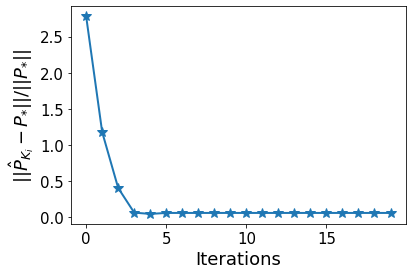

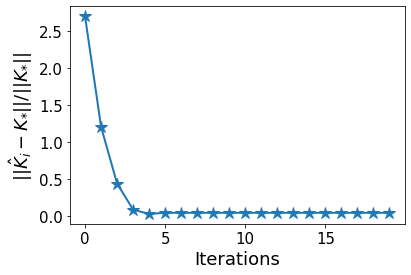

In [ ]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

P_norm = np.zeros(I)
K_norm = np.zeros(I)
for i in range(I):
    P_norm[i] = np.linalg.norm(P_storage[i]-P_opt)/np.linalg.norm(P_opt)
    K_norm[i] = np.linalg.norm(K_storage[i]-K_opt)/np.linalg.norm(K_opt)

It = np.linspace(start=0,stop=I,num=I,endpoint=False)
plt.plot(It, P_norm, '*-', linewidth=2.0, markersize=10)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{P}_{K_i}-P_{*}||}/{||P_{*}||}$', fontsize=18)
plt.show()

plt.plot(It, K_norm, '*-', linewidth=2.0, markersize=12)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{K}_{i}-K_{*}||}/{||K_{*}||}$', fontsize=18)
plt.show()

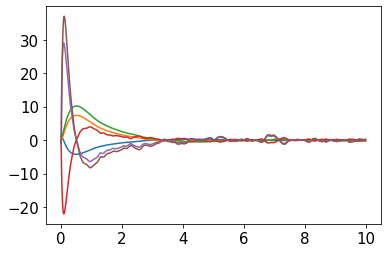

In [ ]:
# test the learned controller
sigma = 0.0
x0 = np.random.normal(0,1,6)
T = np.arange(0., 10.0+dt, dt)
X_test, U_test = int_system(dt, 10.0, x0, K, sigma)
plt.plot(T, X_test)
plt.show()

In [ ]:
print(np.linalg.eig(A-B@K))

print(K_opt)

(array([-228.52427626+0.j        ,  -20.35057374+0.j        ,
         -6.27225581+0.j        ,   -1.88905757+0.54105316j,
         -1.88905757-0.54105316j,   -1.01776696+0.j        ]), array([[-0.00095483+0.j        , -0.01919842+0.j        ,
         0.07145664+0.j        , -0.11989127-0.06841083j,
        -0.11989127+0.06841083j, -0.11010839+0.j        ],
       [ 0.00342452+0.j        ,  0.02026528+0.j        ,
        -0.08113884+0.j        ,  0.36568978+0.10473879j,
         0.36568978-0.10473879j,  0.4847811 +0.j        ],
       [-0.0025513 +0.j        ,  0.04036745+0.j        ,
        -0.11445084+0.j        ,  0.19797369+0.05254045j,
         0.19797369-0.05254045j, -0.49402313+0.j        ],
       [ 0.2182011 +0.j        ,  0.39069883+0.j        ,
        -0.44819432+0.j        ,  0.26349541+0.06436445j,
         0.26349541-0.06436445j,  0.11206468+0.j        ],
       [-0.78258526+0.j        , -0.41241012+0.j        ,
         0.50892356+0.j        , -0.7474783 +0.j        